**Alireza Kheirandish**
97101604

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Embedding, GRU, TimeDistributed

In [2]:
def preprocessing(address):
    text = open(address, 'rb').read().decode(encoding='utf-8')
    text = text[36:]
    return text

**Important**:

Upload ferdousi.text file

In [5]:
text = preprocessing('ferdousi.txt')

print(f'Length of text: {len(text)} characters')
vocab = sorted(set(text))

print(f'{len(vocab)} unique characters')



Length of text: 2554719 characters
46 unique characters


In [6]:
def beyt(list_half_beyt):
  m = list_half_beyt[0::2]
  n = list_half_beyt[1::2]
  temp = list()
  [temp.append(' '.join([i,j])) for i,j in zip(m,n)]
  return temp

In [7]:
type(text)
beyt_ = beyt(text.split('\n'))
beyt_[0]
# [print(len(i)) for i in t[:5]]

'به نام خداوند جان و خرد کزین برتر اندیشه برنگذرد'

In [8]:
k = [len(i) for i in beyt_]
max_len = max(k)
print(max_len)


64


In [9]:
k1 = ["\t" + i for i in beyt_]
temp = [len(i) for i in k1]
# print(max(k))
max_len = max(temp)
print(max_len)
k = [i.ljust(max_len, ' ') for i in beyt_]
k1 = [i.ljust(max_len, ' ') for i in k1]
input_text = "\n".join(k[:-1])
input_text_dec = "\n".join(k1[1:])
output_text = "\n".join(k[1:])
vocab = sorted(set(input_text_dec))
char_map_index = {char: idx for idx,char in enumerate(vocab)}
index_map_char = {idx: char for idx,char in enumerate(vocab)}
k1[:2]


65


['\tبه نام خداوند جان و خرد کزین برتر اندیشه برنگذرد                ',
 '\tخداوند نام و خداوند جای خداوند روزی ده رهنمای                   ']

In [10]:
output_text[:20]

'خداوند نام و خداوند '

In [11]:
maped_input_text_1 = [[char_map_index[i] for i in j] for j in input_text.split('\n')]
maped_input_text_dec_1 = [[char_map_index[i]for i in j] for j in input_text_dec.split('\n')]
maped_output_text_1 = [[char_map_index[i] for i in j] for j in output_text.split('\n')]

In [12]:
maped_input_text = np.asarray(maped_input_text_1,dtype=np.int32)
maped_input_text_dec = np.asarray(maped_input_text_dec_1,dtype=np.int32)
maped_output_text = np.asarray(maped_output_text_1,dtype=np.int32)

In [13]:
# maped_input_text[:10]

In [14]:
len(maped_input_text),len(maped_input_text_dec),len(maped_output_text)

(49607, 49607, 49607)

In [15]:
embedding_dim = len(vocab)
RNN_units = max_len
BATCH_SIZE = 64


In [16]:
def main_model(input_length=max_len,
                         vocab_size=len(vocab), 
                         rnn_units=256,
                         embedding_dim=256,
                         rnn_type="LSTM"):

    enc_inputs = Input(shape=(input_length,))
    embedder = Embedding(vocab_size, embedding_dim)
    enc_input_embed = embedder(enc_inputs)

    if rnn_type == "LSTM":
        enc_rnn_layer = LSTM(rnn_units, return_sequences=True, return_state=True)
        enc_outputs, enc_h, enc_c = enc_rnn_layer(enc_input_embed)
        states = [enc_h, enc_c]
    else:
        enc_rnn_layer = GRU(rnn_units, return_sequences=False, return_state=True)
        _, states = enc_rnn_layer(enc_input_embed)

    dec_inputs = Input(shape=(input_length,))
    embedder1 = Embedding(vocab_size, embedding_dim)
    dec_input_embed = embedder1(dec_inputs)

    if rnn_type == "LSTM":
        dec_rnn_layer = LSTM(rnn_units, return_sequences=True, return_state=True)
        dec_outputs, _, _ = dec_rnn_layer(dec_input_embed, initial_state= states)
    else:
        dec_rnn_layer = GRU(rnn_units, return_sequences=True, return_state=True)
        dec_outputs, _ = dec_rnn_layer(dec_input_embed, initial_state= states)
    
    dec_dense = Dense(vocab_size, activation="softmax")
    dec_output = dec_dense(dec_outputs)

    My_model = Model([enc_inputs, dec_inputs], dec_output)

    return My_model    

**LSTM:**

In [18]:
model_lstm = main_model(rnn_units=RNN_units,
                                  embedding_dim=embedding_dim,
                                  rnn_type="LSTM")

In [19]:
model_lstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 65, 47)       2209        ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 65, 47)       2209        ['input_4[0][0]']                
                                                                                            

In [20]:
model_lstm.layers[1].output[0]

<KerasTensor: shape=(65,) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [21]:
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,\
    save_weights_only=True)

In [22]:

EPOCH = 4
model_lstm.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model_lstm.fit(
    [maped_input_text, maped_input_text_dec],
    maped_output_text,
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
    validation_split=0.2,
    callbacks=[checkpoint_callback],
)

Epoch 1/4
621/621 [==============================] - 85s 129ms/step - loss: 2.1055 - accuracy: 0.4305 - val_loss: 1.8386 - val_accuracy: 0.4744
Epoch 2/4
621/621 [==============================] - 82s 132ms/step - loss: 1.7505 - accuracy: 0.4948 - val_loss: 1.6863 - val_accuracy: 0.5157
Epoch 3/4
621/621 [==============================] - 79s 127ms/step - loss: 1.6289 - accuracy: 0.5305 - val_loss: 1.6082 - val_accuracy: 0.5374
Epoch 4/4
621/621 [==============================] - 79s 128ms/step - loss: 1.5591 - accuracy: 0.5480 - val_loss: 1.5516 - val_accuracy: 0.5517


In [23]:
choosen_beyt = 4
test_input_enc = np.expand_dims(maped_input_text[choosen_beyt], axis = 0)
test_input_dec = np.expand_dims(maped_input_text_dec[choosen_beyt], axis = 0)
test = model_lstm([test_input_enc, test_input_dec]).numpy().argmax(axis = 2)
test_print = ""
for i in test[0]:
    test_print += index_map_char[i]
test_print

'بهامد بر  باادازدرن  با  به بز بر ا بز بامدب بی رنی اه           '

In [24]:
model_lstm([test_input_enc, test_input_dec]).numpy().argmax(axis = 2).shape

(1, 65)

**GRU:**

In [25]:
model_gru = main_model(rnn_units=RNN_units,
                                  embedding_dim=embedding_dim,
                                  rnn_type="GRU")

checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,\
    save_weights_only=True)
EPOCH = 4
model_gru.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model_gru.fit(
    [maped_input_text, maped_input_text_dec],
    maped_output_text,
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
    validation_split=0.2,
    callbacks=[checkpoint_callback],
)

Epoch 1/4
621/621 [==============================] - 72s 110ms/step - loss: 2.0968 - accuracy: 0.4346 - val_loss: 1.7805 - val_accuracy: 0.4870
Epoch 2/4
621/621 [==============================] - 83s 133ms/step - loss: 1.6739 - accuracy: 0.5186 - val_loss: 1.6149 - val_accuracy: 0.5345
Epoch 3/4
621/621 [==============================] - 68s 109ms/step - loss: 1.5543 - accuracy: 0.5496 - val_loss: 1.5373 - val_accuracy: 0.5573
Epoch 4/4
621/621 [==============================] - 68s 110ms/step - loss: 1.4885 - accuracy: 0.5681 - val_loss: 1.4916 - val_accuracy: 0.5697


In [27]:
def Enc_Dec_model(e2e_model, rnn_units=256, rnn_type="LSTM"):

    enc_inputs = e2e_model.input[0]
    if rnn_type == "LSTM":
        a , enc_state_h_, enc_state_c_ = e2e_model.layers[4].output
        enc_states = [enc_state_h_, enc_state_c_]
        enc_model = Model(enc_inputs, [enc_states, a])
        dec_inputs = e2e_model.input[1]
        dec_input_states_h = Input((rnn_units,))
        dec_input_states_c = Input((rnn_units,))
        dec_outputs, dec_output_states_h, dec_output_states_c = e2e_model.layers[5](
            e2e_model.layers[3].output,
            initial_state=[dec_input_states_h,dec_input_states_c])
        dec_output = e2e_model.layers[6](dec_outputs)
        dec_model = Model([dec_inputs,
                           dec_input_states_h,
                           dec_input_states_c],
                          [dec_output,
                           dec_output_states_h,
                           dec_output_states_c])

    else:
        _, enc_states = e2e_model.layers[4].output
        enc_model = Model(enc_inputs, enc_states)
        dec_inputs = e2e_model.input[1]
        dec_input_states = Input((rnn_units,))
        dec_outputs, dec_output_states = e2e_model.layers[4](
            e2e_model.layers[3](dec_inputs),
            initial_state=dec_output_states)
        dec_output = e2e_model.layers[6](dec_outputs)
        dec_model = Model([dec_inputs,
                           dec_input_states],
                          [dec_output,
                           dec_output_states])
    return enc_model, dec_model

In [28]:
encoder_model, decoder_model = Enc_Dec_model(model_lstm, rnn_units=RNN_units, rnn_type="LSTM")

In [29]:
encoder_model.summary(),decoder_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 65)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 65, 47)            2209      
                                                                 
 lstm_2 (LSTM)               [(None, 65, 65),          29380     
                              (None, 65),                        
                              (None, 65)]                        
                                                                 
Total params: 31,589
Trainable params: 31,589
Non-trainable params: 0
_________________________________________________________________
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connec

(None, None)

In [30]:
EPOCH = 40
model_lstm.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model_lstm.fit(
    [maped_input_text, maped_input_text_dec],
    maped_output_text,
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
    validation_split=0.2,
    callbacks=[checkpoint_callback],
    verbose = 0,
)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


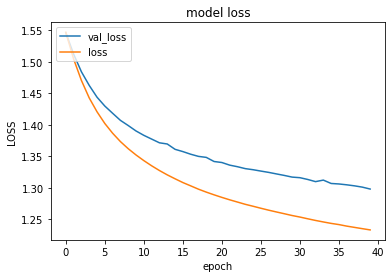

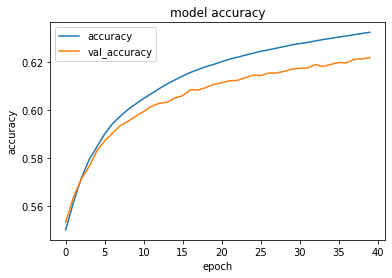

In [232]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

In [233]:
# history.history['val_accuracy']

In [38]:
# def generate_beyt(input_beyt, encoder, decoder):

#     predectid = "\t"
#     output = ""
#     # out_beyt_test = "\t"
#     x, a = encoder.predict(input_beyt)
#     h_st, c_st = x
#     counter = 0
#     while predectid != "\n" and len(output) < max_len:
#         probs, h_st, c_st = decoder.predict([np.array(char_map_index[predectid], int).reshape((1,1)),
#                                            h_st,
#                                            c_st],
#                                             verbose = 0)
#         # probs, h_st, c_st = decoder.predict([np.expand_dims(np.array([char_map_index[i] for i in out_beyt_test]),axis = 0),
#         #                                    h_st,
#         #                                    c_st],
#         #                                     verbose = 0)
#         # print (probs.shape)
#         # probs = probs[:,counter,:]
        

#         probs = probs.flatten()
#         if next_char == " ":
#           probs[2] = probs[2] * (counter/max_len)**20
#         probs = probs/np.sum(probs)
#         predectid = index_map_char[np.random.choice(range(len(probs)), p=probs)]
#         # next_char = idx_to_char[probs.argmax()]
#         output += predectid
#         # out_beyt_test += next_char
#         # print(next_char)
#         # counter += 1
#     return output

In [31]:
choosen_beyt = 7
test = np.expand_dims(maped_input_text[choosen_beyt], axis = 0)
_,test = encoder_model(test_input_enc)
test = test.numpy().argmax(axis = 2)
# print(test.shape)
# .argmax()
# print(test.shape)
test_print = ""
for i in test[0]:
    # print(i)
    test_print += index_map_char[i]
test_print


'کککککککسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسسس'

In [32]:
def generator(input_beyt, encoder, decoder):

    predectid = "\t"
    output = ""
    # out_beyt_test = "\t"
    x, a = encoder.predict(input_beyt)
    h_st, c_st = x
    counter = 0
    while predectid != "\n" and len(output) < max_len:
        probs, h_st, c_st = decoder.predict([np.array(char_map_index[predectid], int).reshape((1,1)),
                                           h_st,
                                           c_st],
                                            verbose = 0)
        

        probs = probs.flatten()
        predectid = index_map_char[np.random.choice(range(len(probs)), p=probs)]
        output += predectid
    return output

In [39]:
choosen_beyt = 5
test = np.expand_dims(maped_input_text[choosen_beyt], axis = 0)
out_seq = generator(test, encoder_model, decoder_model)
in_seq_chars = ""

for i in test[0]:
    in_seq_chars += index_map_char[i]
print(f"Input Sequence: {in_seq_chars}")
print(f"Output Sequence: {out_seq}")

1/1 [==============================] - 0s 35ms/step
Input Sequence: نیابد بدو نیز اندیشه راه که او برتر از نام و از جایگاه           
Output Sequence: زدی بر مرا کوه ازین کژی کنون بر شگفت او نامور نیز زنن            


In [34]:
# np.expand_dims(np.array([char_map_index[i] for i in out_seq]),axis = 0).shape
# test.shape
# # max_len

In [35]:
# char_map_index[" "]

In [36]:
# maped_input_text[0]

In [37]:
# ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
# ids_dataset_decoder = tf.data.Dataset.from_tensor_slices(all_ids_decoder)
# for ids in ids_dataset.take(10):
#     # print((ids.numpy()))
#     print(chars_from_ids(ids).numpy()[0].decode('utf-8'))
      

In [ ]:
# def text_from_ids(ids):
#   return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

# seq_length = max_len

# sequences = ids_dataset.batch(seq_length, drop_remainder=True)
# sequences_decoder = ids_dataset_decoder.batch(seq_length, drop_remainder=True)

# for seq in sequences_decoder.take(3):
#   # print(len(text_from_ids(seq).numpy().decode()))
#   print(text_from_ids(seq).numpy().decode())

کزین برتر اندیشه برنگذرد          

خداوند نام و خداوند جای          
 
خداوند روزی ده رهنمای           


In [ ]:
# def split_input_target(sequence):
#     # print(sequence.shape)
#     input_text = sequence[:-1]
#     target_text = sequence[1:]
#     return input_text, target_text

In [ ]:
# dataset = sequences.map(split_input_target)
# dataset_decoder = sequences_decoder.map(split_input_target)

In [ ]:
# for input_example, target_example in dataset.take(1):
#     print((input_example).shape)
#     print("Input :", text_from_ids(input_example).numpy().decode())
#     print("Target:", text_from_ids(target_example).numpy().decode())

(33,)
Input : به نام خداوند جان و خرد          
Target: ه نام خداوند جان و خرد           


In [ ]:
# BATCH_SIZE = 64
# # BUFFER_SIZE = 128*10

# dataset = (
#     dataset
#     # .shuffle(BUFFER_SIZE)
#     .batch(BATCH_SIZE, drop_remainder=True)
#     .prefetch(tf.data.experimental.AUTOTUNE))

# dataset_decoder = (
#     dataset_decoder
#     # .shuffle(BUFFER_SIZE)
#     .batch(BATCH_SIZE, drop_remainder=True)
#     .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
# for input_example, target_example in dataset_decoder.take(1):
#     print((input_example).shape)
#     print("Input :", text_from_ids(input_example[0]).numpy().decode())
#     print("Target:", text_from_ids(target_example[0]).numpy().decode())

In [ ]:
# vocab_size = len(ids_from_chars.get_vocabulary())

# embedding_dim = 64

# RNN_units = 128

In [ ]:
# class MyModel_LSTM(tf.keras.Model):
#   def __init__(self, vocab_size, embedding_dim, rnn_units):
#     super().__init__(self)
#     self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#     self.LSTM = tf.keras.layers.LSTM(rnn_units,
#                                    return_sequences=False,
#                                    return_state=True)
#     self.LSTM1 = tf.keras.layers.LSTM(rnn_units,
#                                    return_sequences=True,
#                                    return_state=False)
#     self.dense = tf.keras.layers.Dense(vocab_size, activation=tf.keras.activations.softmax)

#   def call(self, inputs, outputs, states=None, return_state=False, training=False):
#     x = inputs
#     # print(x.shape,"X")
#     x = self.embedding(x, training=training)
#     # print(x.shape,"X embedded")
#     if states is None:
#       states = self.LSTM.get_initial_state(x)
#       # print(states,"TRUE STATES")
#     states = self.LSTM(x, initial_state=states, training=training)
#     # print((states[0]).shape,(states[1]).shape,(states[2]).shape,"STATES")
#     y = torch.roll(outputs, 1)
#     # print(y.shape,"Y")
#     y = self.embedding(y, training=training)
#     # print(y.shape,"Y embedded")
#     x = self.LSTM1(y, initial_state=[states[0],states[1]], training=training)
#     x = self.dense(x, training=training)
#     # print(x.shape)
#     # if return_state:
#     #   return x, states
#     # else:
#     return x

In [ ]:
# model1 = MyModel_LSTM(
#     vocab_size=vocab_size,
#     embedding_dim=embedding_dim,
#     rnn_units=RNN_units
#     # ,batch_size = BATCH_SIZE
#     )

In [ ]:
# temp = tf.random.normal([64, 10, 64])
# model1.LSTM(temp,initial_state=model1.LSTM.get_initial_state(temp), training=False)
# model1.LSTM(example_batch_predictions)

In [ ]:
# model1.summary()

Model: "my_model_lstm_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    multiple                  3008      
                                                                 
 lstm_83 (LSTM)              multiple                  98816     
                                                                 
 lstm_84 (LSTM)              multiple                  98816     
                                                                 
 dense_52 (Dense)            multiple                  6063      
                                                                 
Total params: 206,703
Trainable params: 206,703
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# print("Input:\n", text_from_ids(input_example_batch[0]).numpy().decode())
# print()
# print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy().decode())

Input:
 به نام خداوند جان و خرد
کزین برتر اندیشه برنگذرد
خداوند نام و خداوند جای
خداوند روزی ده رهنمای
خداوند کیوان و گردان سپهر
فروزند

Next Char Predictions:
 ددنضپ«زژ«ژهرس)ؤفال،افحئئوکبغ«سعٔ»گغیا مزئنؤن[UNK]دثژبدیع ؤ ؤق(ظضچ[UNK]پٔزث؟«؟ظغرء[UNK]لجژ،ط
ٔورلامل»ضجعم)مطصعکچٔ[UNK]دش صژدض(آغهحٔمپد»»جیجچ،ئآث


In [ ]:
# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
# model1.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [ ]:
# Directory where the checkpoints will be saved
# checkpoint_dir = './training_checkpoints'
# # Name of the checkpoint files
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_prefix,
#     save_weights_only=True)


In [40]:
# EPOCHS = 7
# history = model1.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

dict_keys(['loss', 'accuracy'])


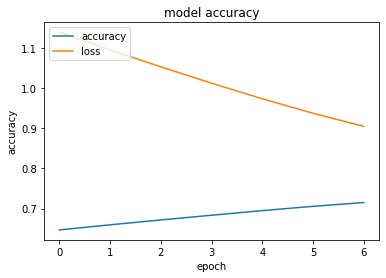

In [ ]:
# import matplotlib.pyplot as plt
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['loss'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['accuracy', 'loss'], loc='upper left')
# plt.show()

In [ ]:
# class OneStep(tf.keras.Model):
#   def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
#     super().__init__()
#     self.temperature = temperature
#     self.model = model
#     self.chars_from_ids = chars_from_ids
#     self.ids_from_chars = ids_from_chars

#     # Create a mask to prevent "[UNK]" from being generated.
#     skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
#     sparse_mask = tf.SparseTensor(
#         # Put a -inf at each bad index.
#         values=[-float('inf')]*len(skip_ids),
#         indices=skip_ids,
#         # Match the shape to the vocabulary
#         dense_shape=[len(ids_from_chars.get_vocabulary())])
#     self.prediction_mask = tf.sparse.to_dense(sparse_mask)

#   @tf.function
#   def generate_one_step(self, inputs, states=None):
#     # Convert strings to token IDs.
#     input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
#     input_ids = self.ids_from_chars(input_chars).to_tensor()

#     # Run the model.
#     # predicted_logits.shape is [batch, char, next_char_logits]
#     predicted_logits, states = self.model(inputs=input_ids, states=states,
#                                           return_state=True)
#     # Only use the last prediction.
#     predicted_logits = predicted_logits[:, -1, :]
#     predicted_logits = predicted_logits/self.temperature
#     # Apply the prediction mask: prevent "[UNK]" from being generated.
#     predicted_logits = predicted_logits + self.prediction_mask

#     # Sample the output logits to generate token IDs.
#     predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
#     predicted_ids = tf.squeeze(predicted_ids, axis=-1)

#     # Convert from token ids to characters
#     predicted_chars = self.chars_from_ids(predicted_ids)

#     # Return the characters and model state.
#     return predicted_chars, states

In [ ]:
# one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
# states = None
# next_char = tf.constant(['مرا مادرم نام مرگ تو هشت'])
# result = [next_char]
# counter = 0
# for n in range(1000):
#   next_char, states = one_step_model.generate_one_step(next_char, states=states)
#   result.append(next_char)
#   if next_char == '\n': 
#     counter += 1
#     if counter == 2:
#       break

# result = tf.strings.join(result)
# print(result[0].numpy().decode('utf-8'))

مرا مادرم نام مرگ تو هشت
یکی خستگیها نشایدت خواست



In [41]:
# tf.saved_model.save(one_step_model, 'one_step')
# one_step_reloaded = tf.saved_model.load('one_step')